# Rocket League Submissions Summary

## Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Read in

In [7]:
matches = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Converters and Functions

In [8]:
converter = { 'bronze': 1, 'silver': 2, 'gold': 3, 'platinum': 4, 'diamond': 5, 'champion': 6 }

In [9]:
def find_outliers(col):

    try:
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR = Q3 - Q1
        lowbound = Q1-1.5*IQR
        highbound = Q3+1.5*IQR
        df_outliers = (col >= lowbound) & (col <= highbound)
    except:
        df_outliers = (col == col)

    return df_outliers

def filter_outliers(df):

    filtered_df = df[df.apply(find_outliers).all(axis = 'columns')]

    return filtered_df

## Notebook : rl_01
### A no-good, very bad model using "relevant" car names and logistic regression

In [10]:
X = matches[['car_name']]
y = matches[['rank']]

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, random_state=42)

onehot = OneHotEncoder(handle_unknown = 'ignore')

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}
logreg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
gs_model = GridSearchCV(logreg, param)

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('gs_model', gs_model)
])

pipeline.fit(X_train_0, y_train_0.values.ravel())

best_params = pipeline['gs_model'].best_params_

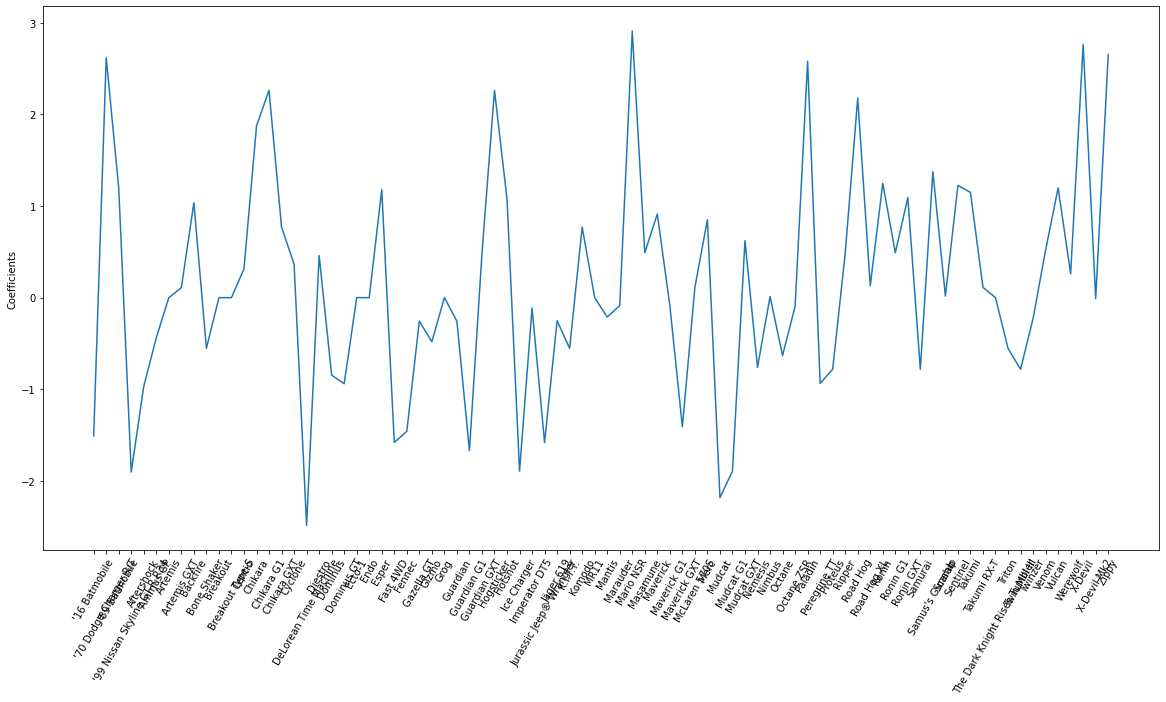

In [11]:
logreg = LogisticRegression(**best_params, penalty = 'l1', solver = 'liblinear')

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('logreg', logreg)
])

pipeline.fit(X_train_0, y_train_0.values.ravel())
coefs = pipeline['logreg'].coef_[0]

car_cols = pd.get_dummies(matches['car_name']).columns

plt.subplots(figsize = (20, 10))
_ = plt.plot(range(len(car_cols)), coefs)
_ = plt.xticks(range(len(car_cols)), car_cols, rotation = 60)
_ = plt.ylabel('Coefficients')
plt.show()

In [12]:
relevant_cars = pd.get_dummies(matches['car_name']).columns[coefs != 0]
X = matches.loc[matches['car_name'].isin(relevant_cars), ['car_name']]
y = matches.loc[matches['car_name'].isin(relevant_cars), ['rank']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

onehot = OneHotEncoder(handle_unknown='ignore')

logreg = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('logreg', logreg)
])

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.2561446272598009
[[  16    7  178   52   76   20]
 [   1   36 1814   59 1067    6]
 [   4   27 1967   88 1278   23]
 [   9   25 1554  300 1052   57]
 [   2   36 1979  203 1406   35]
 [  10   10  651  153  510   58]]
              precision    recall  f1-score   support

      bronze       0.38      0.05      0.08       349
    champion       0.26      0.01      0.02      2983
     diamond       0.24      0.58      0.34      3387
        gold       0.35      0.10      0.16      2997
    platinum       0.26      0.38      0.31      3661
      silver       0.29      0.04      0.07      1392

    accuracy                           0.26     14769
   macro avg       0.30      0.19      0.16     14769
weighted avg       0.28      0.26      0.20     14769



In [13]:
pipeline.fit(X, y.values.ravel())
tester = test[['car_name']]

y_pred = pipeline.predict(tester)

y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})

submission = submission.drop_duplicates(subset = 'match_id')
#submission.to_csv('../submissions/submission_2022-03-24_v1.csv', index = False)

## Notebook: rl_02
### Build a kitchen-sink model

In [14]:
matches_prepped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]


pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))


Accuracy Score:  0.5529146195724339
Confusion Matrix: 
 [[  55    0    2   27    7   93]
 [   0 1020  399    2   49    0]
 [   1  403  832   35  456    2]
 [   8    0   53  920  444  138]
 [   2   37  416  414  995   11]
 [  26    1    4  304   33  342]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.60      0.30      0.40       184
    champion       0.70      0.69      0.70      1470
     diamond       0.49      0.48      0.48      1729
        gold       0.54      0.59      0.56      1563
    platinum       0.50      0.53      0.52      1875
      silver       0.58      0.48      0.53       710

    accuracy                           0.55      7531
   macro avg       0.57      0.51      0.53      7531
weighted avg       0.55      0.55      0.55      7531



In [15]:
pipeline.fit(X, y.values.ravel())
test_prep = test.groupby(['match_id']).mean().fillna(0)
y_pred = pipeline.predict(test_prep)
y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test_prep.reset_index()['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})

#submission.to_csv("../submissions/submission_2022-03-25_v1.csv", index = False)

## Notebook: rl_03
### Build a refined kitchen-sink model

In [16]:
matches_prepped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 1000))
    ])

param_grid = {'logreg__C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(pipe, param_grid, scoring = 'accuracy', verbose=2)

rs.fit(X_train, y_train)

y_pred = rs.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  10.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=   9.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  10.4s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  12.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  11.9s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  10.9s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  11.4s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  10.1s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  10.2s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=   9.8s
[CV] END ......................................logreg__C=1.0; total time=   9.3s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=   8.7s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=  10.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=   8.3s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=   7.3s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   3.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   3.7s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   3.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   3.7s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   3.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   1.7s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   2.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   2.0s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   2.1s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   2.0s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score:  0.555171955915549
Confusion Matrix: 
 [[  56    0    4   26    7   91]
 [   0 1017  400    3   50    0]
 [   1  394  841   33  459    1]
 [   7    0   54  914  441  147]
 [   2   39  417  404 1002   11]
 [  29    1    5  290   34  351]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.59      0.30      0.40       184
    champion       0.70      0.69      0.70      1470
     diamond       0.49      0.49      0.49      1729
        gold       0.55      0.58      0.57      1563
    platinum       0.50      0.53      0.52      1875
      silver       0.58      0.49      0.54       710

    accuracy                           0.56      7531
   macro avg       0.57      0.52      0.53      7531
weighted avg       0.56      0.56      0.55      7531



In [17]:
rs.fit(X, y)

test_prep = test.groupby('match_id').mean().fillna(0)
y_pred = rs.predict(test_prep)
y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test_prep.reset_index()['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})
#submission.to_csv("../submissions/submission_2022-03-28_v1.csv", index = False)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

[CV] END ......................................logreg__C=100; total time=  17.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  19.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  17.6s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  18.2s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=100; total time=  16.7s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  17.3s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  18.1s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  17.3s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  17.6s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................................logreg__C=10; total time=  16.4s
[CV] END ......................................logreg__C=1.0; total time=  13.2s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=  14.0s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=  16.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=  13.6s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=1.0; total time=  15.6s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   7.2s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   7.1s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   6.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   6.2s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................................logreg__C=0.1; total time=   6.5s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   3.4s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   3.0s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   3.1s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   2.8s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................................logreg__C=0.01; total time=   3.0s


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Notebook: rl_05
### (I) First Neural Network (Kitchen Sink Approach)

In [18]:
matches_prepped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped['rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('neural', MLPClassifier(hidden_layer_sizes = (10,10),
                                 activation = 'tanh',
                                 max_iter = 1000))
    ])

pipe.fit(X_train, y_train)

print(accuracy_score(y_test, pipe.predict(X_test)))
print(classification_report(y_test, pipe.predict(X_test)))

0.5580932147125216
              precision    recall  f1-score   support

      bronze       0.56      0.38      0.45       184
    champion       0.72      0.65      0.68      1470
     diamond       0.49      0.51      0.50      1729
        gold       0.55      0.60      0.57      1563
    platinum       0.51      0.53      0.52      1875
      silver       0.60      0.50      0.55       710

    accuracy                           0.56      7531
   macro avg       0.57      0.53      0.55      7531
weighted avg       0.56      0.56      0.56      7531



In [19]:
pipe.fit(X, y)

test_prep = test.groupby('match_id').mean().reset_index().fillna(0)
y_pred = pipe.predict(test_prep.drop(columns = 'match_id'))

submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-03-30_v1.csv', index = False)

## Notebook: rl_07
### (I) Logistic Regression, matches grouped with mean, outliers filtered

In [20]:
matches_prepped = filter_outliers(matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0))

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [

        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 1000))
    ])

param_grid = {'logreg__C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(pipe, param_grid, scoring = 'accuracy')

rs.fit(X_train, y_train)

y_pred = rs.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

Accuracy Score:  0.5811900191938579
Confusion Matrix: 
 [[  0   0   2   4   2  12]
 [  0 808 308   2  29   0]
 [  0 275 734  19 331   0]
 [  0   1  34 599 333  40]
 [  1  30 315 269 780   5]
 [  2   0   0 155  13 107]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.00      0.00      0.00        20
    champion       0.73      0.70      0.71      1147
     diamond       0.53      0.54      0.53      1359
        gold       0.57      0.59      0.58      1007
    platinum       0.52      0.56      0.54      1400
      silver       0.65      0.39      0.49       277

    accuracy                           0.58      5210
   macro avg       0.50      0.46      0.48      5210
weighted avg       0.58      0.58      0.58      5210



In [21]:
test_prep = test.groupby('match_id').mean().fillna(0)
y_pred = rs.predict(test_prep)
y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test_prep.reset_index()['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})
#submission.to_csv("../submissions/submission_2022-04-01_v1.csv", index = False)

### (II) Logistic Regression, matches grouped with mean, outliers filtered by rank

In [ ]:
# matches_grouped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)
# matches_grouped_fo = matches_grouped.groupby('rank').apply(filter_outliers)
# matches_grouped_fo.index = matches_grouped_fo.index.droplevel(level = 0)
# matches_grouped_fo

In [22]:
matches_grouped_fo = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0).groupby('rank').apply(filter_outliers)
X = matches_grouped_fo.drop(columns = ['match_id', 'rank'])
y = matches_grouped_fo[['rank']]

X_train, X_test, y_train, y_test =train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 1000))
    ])

param_grid = {'logreg__C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(pipe, param_grid, scoring = 'accuracy')

rs.fit(X_train, y_train)

y_pred = rs.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

Accuracy Score:  0.6080092414324221
Confusion Matrix: 
 [[ 41   0   0   8   0  49]
 [  0 772 267   0  17   0]
 [  0 252 670  11 305   0]
 [  3   0  15 656 305  77]
 [  0  15 285 237 786   1]
 [ 21   0   0 159   9 233]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.63      0.42      0.50        98
    champion       0.74      0.73      0.74      1056
     diamond       0.54      0.54      0.54      1238
        gold       0.61      0.62      0.62      1056
    platinum       0.55      0.59      0.57      1324
      silver       0.65      0.55      0.60       422

    accuracy                           0.61      5194
   macro avg       0.62      0.58      0.59      5194
weighted avg       0.61      0.61      0.61      5194



In [23]:
rs.fit(X, y)

test_prep = test.groupby('match_id').mean().reset_index().fillna(0)
y_pred = rs.predict(test_prep.drop(columns = 'match_id'))

submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-04-02_v1.csv', index = False)

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

### (III) Logistic Regression, grouped with mean, outiers removed by rank, resampled

There's an error when fitting the test data here.

In [24]:
X = matches_grouped_fo.drop(columns = ['match_id', 'rank'])
y = matches_grouped_fo['rank']

pipe_trans = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
])

X_trans = pipe_trans.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, random_state=42, stratify = y)

sm = SMOTE(random_state=42)
X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

logreg = LogisticRegression(max_iter = 1000)

param_grid = {'C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(logreg, param_grid, scoring = 'accuracy')

rs.fit(X_train_rs, y_train_rs)

y_pred = rs.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

Accuracy Score:  0.5943396226415094
Confusion Matrix: 
 [[ 70   0   0   5   0  23]
 [  0 806 235   0  15   0]
 [  1 294 646  15 282   0]
 [  9   0  18 610 244 175]
 [  0  18 304 290 702  10]
 [ 77   0   0  86   6 253]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.45      0.71      0.55        98
    champion       0.72      0.76      0.74      1056
     diamond       0.54      0.52      0.53      1238
        gold       0.61      0.58      0.59      1056
    platinum       0.56      0.53      0.55      1324
      silver       0.55      0.60      0.57       422

    accuracy                           0.59      5194
   macro avg       0.57      0.62      0.59      5194
weighted avg       0.59      0.59      0.59      5194



C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
rs.fit(X_trans, y)

test_prep = test.groupby('match_id').mean().reset_index().drop(columns = ['match_id', 'assists', 'mvp']).fillna(0)
test_prep_trans = pipe_trans.fit_transform(test_prep)
y_pred = rs.predict(test_prep_trans)

submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-04-02_v2.csv', index = False)

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

### Error in training for submission_2022-04-02_v2.csv. Adjusted below.

In [26]:
X = matches_grouped_fo.drop(columns = ['match_id', 'rank'])
y = matches_grouped_fo['rank']

pipe_trans = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
])

X_trans = pipe_trans.fit_transform(X)

sm = SMOTE(random_state=42)
X_rs, y_rs = sm.fit_resample(X_trans, y)

logreg = LogisticRegression(max_iter = 1000)

param_grid = {'C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(logreg, param_grid, scoring = 'accuracy')

rs.fit(X_rs, y_rs)

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000),
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01]},
                   scoring='accuracy')

In [27]:
test_prep = test.groupby('match_id').mean().reset_index().drop(columns = ['match_id', 'assists', 'mvp']).fillna(0)

test_prep_trans = pipe_trans.fit_transform(test_prep)
y_pred = rs.predict(test_prep_trans)

submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-04-03_v1.csv', index = False)

### (VI) Logistic Regression, select columns, grouped with mean, outiers removed by rank, resampled
### (VIa) RFE Feature Selection with data grouped with mean

In [29]:
dropcols = ['match_id', 'rank']

matches_cols_grouped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)
matches_cols_grouped_fo = matches_cols_grouped.groupby('rank').apply(filter_outliers)
matches_cols_grouped_fo.index = matches_cols_grouped_fo.index.droplevel(level = 0)

X = matches_cols_grouped_fo.drop(columns = dropcols)
y = matches_cols_grouped_fo['rank']
logreg = LogisticRegression(max_iter=1000)
selector = RFE(logreg, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
selected_cols = selector.support_
best15 = X.columns[selected_cols]

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [30]:
X = matches_cols_grouped_fo[best15]
y = matches_cols_grouped_fo['rank']

pipe_trans = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
])

X_trans = pipe_trans.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, random_state=42, stratify = y)

sm = SMOTE(random_state=42)
X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

logreg = LogisticRegression(max_iter = 1000)

param_grid = {'C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(logreg, param_grid, scoring = 'accuracy')

rs.fit(X_train_rs, y_train_rs)

y_pred = rs.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

Accuracy Score:  0.5390835579514824
Confusion Matrix: 
 [[ 73   0   0   5   1  19]
 [  0 769 252   1  34   0]
 [  1 339 580  28 290   0]
 [ 27   1  32 517 268 211]
 [  2  39 312 302 634  35]
 [ 92   0   0  92  11 227]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.37      0.74      0.50        98
    champion       0.67      0.73      0.70      1056
     diamond       0.49      0.47      0.48      1238
        gold       0.55      0.49      0.52      1056
    platinum       0.51      0.48      0.49      1324
      silver       0.46      0.54      0.50       422

    accuracy                           0.54      5194
   macro avg       0.51      0.57      0.53      5194
weighted avg       0.54      0.54      0.54      5194



C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
X = matches_cols_grouped_fo[best15]
y = matches_cols_grouped_fo['rank']

pipe_trans = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
])

X_trans = pipe_trans.fit_transform(X)

sm = SMOTE(random_state=42)
X_rs, y_rs = sm.fit_resample(X_trans, y)

logreg = LogisticRegression(max_iter = 1000)

param_grid = {'C':[100, 10, 1.0, 0.1, 0.01]}

rs = RandomizedSearchCV(logreg, param_grid, scoring = 'accuracy')

rs.fit(X_rs, y_rs)

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000),
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01]},
                   scoring='accuracy')

In [32]:
test_grouped = test.groupby('match_id')[best15].mean().reset_index().fillna(0)
test_trans = pipe_trans.fit_transform(test_grouped.drop(columns = 'match_id'))
y_pred = rs.predict(test_trans)

submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-04-03_v2.csv', index = False)
#submission.to_csv('../submissions/submission_2022-04-04_v1.csv', index = False)

## Notebook: rl_06
### (IX) Gradient Boost Classifier, grouped by match_id and aggregated by mean, outliers removed by rank, no cars

In [33]:
dropcols = ['match_id', 'rank']

X = matches_grouped_fo.drop(columns = dropcols)
y = matches_grouped_fo['rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('gbc', GradientBoostingClassifier())
    ])

pipe.fit(X_train, y_train)
accuracy_score(y_test, pipe.predict(X_test))

0.5721986907970735

In [34]:
dropcols = ['match_id', 'rank']

X = matches_grouped_fo.drop(columns = dropcols)
y = matches_grouped_fo['rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline(steps = [
        ('vt', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('gbc', GradientBoostingClassifier())
    ])

pipe.fit(X, y)
accuracy_score(y, pipe.predict(X))

0.6745126353790614

In [35]:
test_prep = test.groupby('match_id').mean().reset_index().fillna(0)
y_pred = pipe.predict(test_prep.drop(columns='match_id'))
submission = pd.DataFrame({'match_id':test_prep.index, 'rank': y_pred})
submission['rank'] = submission['rank'].map(converter)
submission['match_id'] = submission['match_id']+30121
#submission.to_csv('../submissions/submission_2022-04-03_v3.csv', index = False)